# Introduction to Federated Learning Locally and on GCP's Vertex AI 

  

## Overview
Federated Learning is a privacy preserving technique to train machine learning models.
When dealing with secure data (e.g. patient data) it is often restricted to merge datasets from different institutions (clients).
Federated Learning enables the training of a machine learning model without sharing the underlying data.
This is achieved by training local models at each client and only aggreagating the model weights. Instead of sending raw data to a central server, each client trains the model locally on its own data and only shares the model's updates (e.g., weights or gradients) with the central server. The server aggregates these updates (e.g., using algorithms like Federated Averaging, or FedAvg) to improve the global model.

This approach is particularly useful in scenarios where data privacy, security, or bandwidth constraints make it impractical to centralize data.

In this tutorial we will focus on centralized horizontal Federated Learning. Centralized FL has a coordinating server that controls the learning process and aggreagates the model weights [1].
Horizontal FL means that the same features are available on each client (e.g. images) [2].
The pendant to that would be vertical FL where different features are present, but for the same sample (e.g. patient).

This is the general overview of a federated learning training process.
The image was taken from the [NVIDIA blog](https://blogs.nvidia.com/blog/what-is-federated-learning/) and slightly modified.

<img src="../../images/federated_learning_animation_still_white.png" width="800">

The training process can be split up in [5 steps](https://flower.ai/docs/framework/tutorial-series-what-is-federated-learning.html):

0. Initialize the global model
1. Send global model to clients
2. Local training
3. Return model updates to coordinator
4. Aggregate model updates by averaging (FedAvg)
5. Repeat steps 1 to 4 until convergence



FL workflows typically include the following steps which we will go over in this tutorial:

1. **Data Preparation:** Split the data across multiple clients.
2. **Client Training:** Each client trains a local model on its data.
3. **Model Aggregation:** The server aggregates the client models using algorithms like Federated Averaging (FedAvg).
4. **Evaluation:** Evaluate the aggregated model.
5. **Repeat:** Iterate for multiple rounds (epochs).

## Prerequisites

This notebooks was run using the machinetype n1-highcpu-8 (8 vCPUs, 7.199 GB RAM) on Pytorch. Ensure Vertex AI and Cloud Storage APIs are enabled. Visit the following tutorial to set up notebooks that utilize: [GPUs Spinning up a Vertex AI Notebook](https://github.com/STRIDES/NIHCloudLabGCP/blob/42ee2b7dbffce54e53a212d8c02ac16fd872c5be/docs/vertexai.md) for faster speeds if needed.

## Learning Objectives
* Understand Federated Learning 
* Learn to created a Centralized training and Federated Learning workflows locally
* Learn how to adapt the federated learning process to Google Clouds' Vertex AI.
* Evaluate and visualize model performance Centralized training vs. Federated Learning

## Get Started

Install the following packages. In this tutorial we are using the **Pytorch Kernel** in a Vertex AI Workbench Jupyter Notebook which has Pytorch preinstalled. If you are not using the same setting you can install the rest of the needed packages by running `pip install torch pandas scikit-learn matplotlib ordereddict`.

The kfp package will allow us to complie the functions that we are about to make into a pipeline which we will use in a later step.

In [166]:
! pip install google-cloud-aiplatform kfp

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


Import our packages and functions.

In [167]:
import os
import torch

import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from kfp.v2 import compiler
from torch.nn import Sequential
from collections import OrderedDict
from google.cloud import aiplatform
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from kfp.v2.dsl import component, Output, Dataset, Model, Input, Artifact, Metrics
from sklearn.preprocessing import StandardScaler

### Centralized Training

As a first step we demonstrate the training of a ML model through a traditional, centralized training. Although this is not a prerequisite for Federated Learning both trainings share many of the same steps and we will be comparing the accuracy of the two trainings (Centralized Training vs.Federated Learning). It will also help us determine if our model is trainable.

To start centralized training we first define a class called `BreastCancerDataset`. In this tutorial we are using the Breast Cancer Wisconsin (Diagnosic) datset [3]. It contains 30 features, computed from digitized breast cancer images. The task is to perform binary classification into the two classes "malignant" (=1) and "benign" (=0).

If you are done with the tutorial and understand the main principles of federated learning, you can create your own data classes here.

#### 1. Data Prep
We have already split our data into training and validation datasets which you can see in the `data` directory. 

The class below main function is to take a standardize the feature columns within a dataframe (excluding the first column, which is an ID, and the last column, which is the diagnosis label). By standardizing our features we avoid any outliers that may cause our model to become biased in training. 

Then it converts the standardized features into a PyTorch tensor (`self.X`). Extracts the diagnosis labels (malignant = 1, benign = 0) from the last column of the DataFrame and converts them into a PyTorch tensor (`self.y`).

We will use this class for federated learning as well.

In [168]:
class BreastCancerDataset(Dataset):
    def __init__(self, df):
        scaler = StandardScaler()
        self.X = torch.tensor(scaler.fit_transform(df.iloc[:,1:-1].values))   # first (ID) and last (diagnisis) columns are excluded
        self.y =  torch.tensor(df.iloc[:,-1].values)                          # load the diagnosis (malignant=1, benign=0)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

After defining the class for our dataset we load it.
The data is split in a train and validation subset.
The loaded instance is additionaly wrapped into a PyTorch `DataLoader()` object.
This makes the dataset accessible to the model during training.

In [169]:
train_df = pd.read_csv(os.path.join("data", "full_train_data.csv"), dtype=np.float32)
val_df = pd.read_csv(os.path.join("data", "full_val_data.csv"), dtype=np.float32)

train_data = BreastCancerDataset(train_df)
val_data = BreastCancerDataset(val_df)

train_dataloader = DataLoader(train_data, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=50, shuffle=False)

#### 2. Define Client class for model training and validation 

Now we define a `Client` class that is used for the training.
The client receives the model and the train and validation data loaders.
The class will be used for the centralized and federated training.

The class contains two functions:
- `train()` runs the training of the model
- `validate()` runs the validation of the model on the given `val_loader`

The `train` function in the `Client` class trains the client's local model for one epoch using its assigned training data. It iterates through the training dataset in batches, computes predictions using the model, and calculates the loss with the specified loss function (`criterion`). The function performs backpropagation by calculating gradients and updating the model's weights using the optimizer. It also tracks the number of correct predictions to compute the training accuracy for the epoch. Finally, it records the epoch's loss and accuracy in the client's `metrics` dictionary for later evaluation and visualization.

The `validate` function in the `Client` class evaluates the client's local model using its validation dataset. It sets the model to evaluation mode (`model.eval()`) to disable dropout and other training-specific behaviors. The function iterates over the validation dataset (similar to the training dataset), computes predictions, and calculates the loss for each batch without updating the model's weights. It also tracks the number of correct predictions to compute the validation accuracy. Finally, it records the average loss and accuracy for the validation epoch in the client's `metrics` dictionary for later analysis.


In [170]:
class Client:
    def __init__(self, name, model, train_loader, val_loader, optimizer, criterion):
        self.name = name
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.metrics = dict({"train_acc": list(), "train_loss": list(), "val_acc": list(), "val_loss": list()})

        print(f"[INFO] Initialized client '{self.name}' with {len(train_loader.dataset)} train and {len(val_loader.dataset)} validation samples")
        
        
    def train(self):
        """
            Trains the model of the client for 1 epoch.
        """
        self.model.train()
        correct_predictions = 0
        running_loss = 0.0

        # iterate over training dataset
        for inputs, labels in self.train_loader:
            # make predictions
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            labels = torch.unsqueeze(labels, 1)

            # apply gradient
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

            # calculate number of correct predictions
            predicted = torch.round(outputs)
            correct_predictions += (predicted == labels).sum().item()

        # calculate overall loss and acc.
        epoch_loss = running_loss / len(self.train_loader)
        accuracy = correct_predictions / len(self.train_loader.dataset)

        # save metrics
        self.metrics["train_acc"].append(accuracy)
        self.metrics["train_loss"].append(epoch_loss)
    
    def validate(self):
        """
            Validates the model of the client based on the given validation data loader.
        """
        self.model.eval()
        total_loss = 0
        correct_predictions = 0

        # iterate over validation data loader and make predictions
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                outputs = self.model(inputs)
                labels = torch.unsqueeze(labels, 1)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                predicted = torch.round(outputs)
                correct_predictions += (predicted == labels).sum().item()

        # calculate overall loss and acc.
        average_loss = total_loss / len(self.val_loader)
        accuracy = correct_predictions / len(self.val_loader.dataset)

        # save metrics
        self.metrics["val_acc"].append(accuracy)
        self.metrics["val_loss"].append(average_loss)

#### 3. Defining the model

Now that we have our data set up and the client defined we can define our model!

The `SimpleNN` class defines a simple and small feedforward neural network for binary classification tasks. It contains three linear layers, with only a few nodes each. The network takes an input of a specified size (`n_input`), processes it through the layers, and outputs a single value between 0 and 1, representing the probability of the positive class. It is designed to be lightweight and efficient, making it suitable for use in both centralized and federated learning scenarios. The `forward` method defines how the input data flows through the network during training and inference.

After finishing the tutorial feel free to come back to here and implement your own models.



In [171]:
class SimpleNN(nn.Module):
    def __init__(self, n_input):
        super(SimpleNN, self).__init__()
        self.NN = Sequential(
            nn.Linear(n_input, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.NN(x)
        return logits

The `n_input` is set to 30 because the input layer of the `SimpleNN` neural network is designed to accept 30 features (or columns) as input. This matches the number of standardized feature columns in the dataset used for training and validation. In the context of the `BreastCancerDataset` class, the dataset contains 30 numerical features after excluding the ID column and the diagnosis label column. These 30 features are then fed into the neural network to make predictions.

In [172]:
model = SimpleNN(n_input=30)

#### 4. Initalizing the client

With the model available we can set up our client that is used for centralized training.

The `optimizer` is responsible for updating the model's parameters (weights) during training to minimize the loss function. It uses the gradients computed during backpropagation to adjust the weights in the direction that reduces the loss.

The `criterion` is the loss function used to measure how well the model's predictions match the true labels. It calculates the error between the predicted outputs and the actual targets, which the optimizer then tries to minimize.

All of these functions are inputed into `central_client` to start the centralized training. after running this cell you should see an output stating that the client has been initialized this mean that the client has been created!

For this example the client has been assigned 397 samples for training and 172 samples for validation. 

In [173]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.BCELoss()
central_client = Client("central", model, train_dataloader, val_dataloader, optimizer, criterion)

[INFO] Initialized client 'central' with 397 train and 172 validation samples


#### 5. Begin training the model

Now we can start the training. Using the `central_client` that we just initalized we run training and validation for 10 epochs, where in each epoch we train the model once on all training samples and adapt the model. Then we validate the updated model.

In [174]:
epochs = 10
for i in range(epochs):
    print(f"Epoch {i}")
    # run one training epoch
    central_client.train()
    
    # run validation of training epoch
    central_client.validate()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


#### 6. Plotting Metrics to confrim convergence

After training we plot the training and validation metrics to check for convergence of the model by monitoring the loss and accuracy over multiple epochs. Lets take a look at what some of the metrics mean.

- **Training loss:** Measures how well the model is fitting the training data. A decreasing training loss over epochs indicates that the model is learning from the training data.
- **Training accuracy:** Tracks the proportion of correct predictions on the training dataset. An increasing training accuracy suggests that the model is improving its ability to classify the training samples correctly.
- **Validation loss:** Measures how well the model generalizes to unseen data (validation dataset). A decreasing validation loss indicates better generalization, while an increasing loss may suggest overfitting.
- **Validation accuracy:** Tracks the proportion of correct predictions on the validation dataset. An increasing validation accuracy indicates that the model is improving its performance on unseen data.

The model is considered to be converging when the training and validation losses stabilize (stop decreasing significantly) and the validation accuracy reaches a plateau.
If the validation loss starts increasing while the training loss continues to decrease, it may indicate overfitting, meaning the model is memorizing the training data instead of generalizing.

In [175]:
def plot_metrics(client, op_save):
    plt.figure(figsize=(8, 4))
    for k, v in client.metrics.items():
        x_vals = range(len(v))
        plt.plot(x_vals, v, label=k)

    plt.ylim(bottom=0.0, top=1.0)
    plt.xlim(left=0)
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title(client.name)
    plt.legend()
    plt.show()
    if op_save is not None:
        plt.savefig(op_save.path)
    plt.close()

Run the code cell below to see a visual of our model metrics! 

**Note:** This function also lets you save the image as a file which we will do later during the Vetex AI Federated Learning portion of this tutorial. If you would like to do this now you can change the `None` value to a file path.

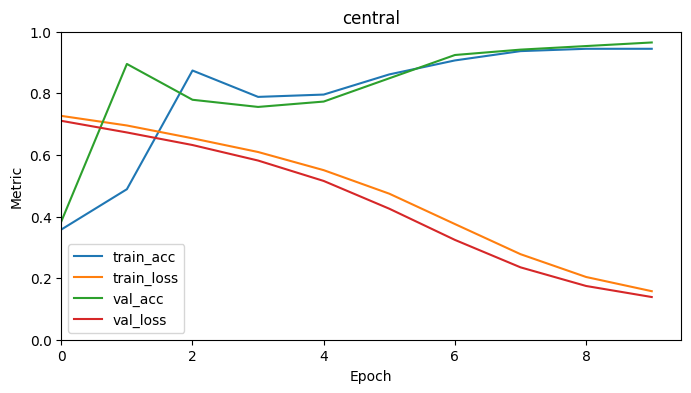

In [176]:
plot_metrics(central_client, None)

#### 7. Evaluating the model

Additionally, we evaluate the model on the validation dataset. The `run_predictions` function below will iterate through the validation dataset, computes predictions using the model, and rounds the outputs to classify them as either 0 or 1 ("malignant" (=1) and "benign" (=0).).

It compares the predicted labels with the true labels and counts the number of correct predictions.
The accuracy is computed as the ratio of correct predictions to the total number of samples in the validation dataset.

In [177]:
def run_prediction(model, test_data_path):
    model.eval()
    
    test_df = pd.read_csv(test_data_path, dtype=np.float32)
    test_data = BreastCancerDataset(test_df)
    test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

    correct_predictions = 0

    # iterate over validation data loader and make predictions
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            labels = torch.unsqueeze(labels, 1)
            predicted = torch.round(outputs)
            correct_predictions += (predicted == labels).sum().item()

    # calculate overall acc.
    accuracy = correct_predictions / len(test_dataloader.dataset)
    
    print(f"{accuracy:.2f}")

Lets run the cell below to see our models perdiction accuracy!

In [178]:
print("Accuracy of the centrally trained model:")
run_prediction(central_client.model, 'data/full_val_data.csv')

Accuracy of the centrally trained model:
0.97


The train and validation accurracy increases upon the epochs, while the loss decreases.
This is a sign that our model converges and we can move on to implement federated learning.

### Implementing Federated Learning locally

Now that we have shown that our model is trainable with the given breast cancer dataset, we can implement federated learning!

In the `data` folder there there are two clients already prepared for this tutorial (`client_0`, `client_1`).
The data was presplit homogeneously accross the three clients, stratified by diagnosis.

Just like in centralized data we are going to prep our data then we initialize each client, using the centrally initiallized model (Steps 1-4).



In [179]:
fed_model = SimpleNN(n_input=30)
# initialize clients
clients = list()
for i in range(2):
    train_df = pd.read_csv(os.path.join("data", f"client_{i}", "train_data.csv"), dtype=np.float32)
    val_df = pd.read_csv(os.path.join("data", f"client_{i}", "val_data.csv"), dtype=np.float32)
    
    train_data = BreastCancerDataset(train_df)
    val_data = BreastCancerDataset(val_df)

    train_dataloader = DataLoader(train_data, batch_size=7, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=7, shuffle=False)

    optimizer = torch.optim.SGD(fed_model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.BCELoss()
    
    clients.append(Client(f"client_{i}", fed_model, train_dataloader, val_dataloader, optimizer, criterion))

[INFO] Initialized client 'client_0' with 199 train and 86 validation samples
[INFO] Initialized client 'client_1' with 198 train and 86 validation samples


#### Define model aggregation

This step is new and unique to Federated Learning because we need to define a function that aggregates the model weights. In this tutorial we use the basiv FedAvg algorithm for that [4]. It calculates the weighted mean for each node in the neural network.

In [180]:
def fed_avg(global_state_dict, client_states, n_data_points):
    """
    Averages the weights of client models to update the global model by FedAvg.

    Args:
        global_state_dict: The state dict of the global PyTorch model.
        client_states: A list of PyTorch models state dicts representing client models.
        n_data_points: A list with the number of data points per client.

    Returns:
        The state dict of the updated global PyTorch model.
    """
    averaged_state_dict = OrderedDict()

    for key in global_state_dict.keys():
        for state, n in zip(client_states, n_data_points):
            averaged_state_dict[key] =+ state[key] * (n/ sum(n_data_points))
   
    return averaged_state_dict

#### Definition of a coordination server

To orchestrate the federated learning process we define a coordination server.
It has just one function that runs the federated learning training.
The function loops over the clients and trains one epoch on each client.
Then the updated models are aggregated by the FedAvg function.
The updated models are sent back to the clients before validation.

In [181]:
class FLServer:
    def __init__(self, model, clients):
        self.model = model
        self.clients = clients
        self.n_data_points = [len(client.train_loader.dataset) for client in self.clients]

    def run(self, epochs):
        for i in range(epochs):
            print(f"Epoch {i}")

            # Step 2 of figure at the beginning of the tutorial
            for client in self.clients:
                client.train()

            # aggregate the models using FedAvg (Step 3 & 4 of figure at the beginning of the tutorial)
            client_states = [client.model.state_dict() for client in self.clients]                 # Step 3
            aggregated_state = fed_avg(self.model.state_dict(), client_states, self.n_data_points) # Step 4
            self.model.load_state_dict(aggregated_state)
            
            # redistribute central model (Step 1 of figure at the beginning of the tutorial)
            for client in fl_server.clients:
                client.model.load_state_dict(aggregated_state)

            # run validation of aggregated model
            for client in self.clients:
                client.validate()

            # repeat for n epochs (Step 5 of figure at the beginning of the tutorial

Now we can finally start our federated training by calling the `run()` function

In [182]:
fl_server = FLServer(fed_model, clients)
# distribute the central model to all clients (Step 1 of figure at the beginning of the tutorial)
for client in fl_server.clients:
    client.model.load_state_dict(fl_server.model.state_dict())

#run training with server
fl_server.run(epochs=10)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


After training is completed we can again have a look at the convergence of the model.
In this case we get one plot for each client, containing accurracy and loss.

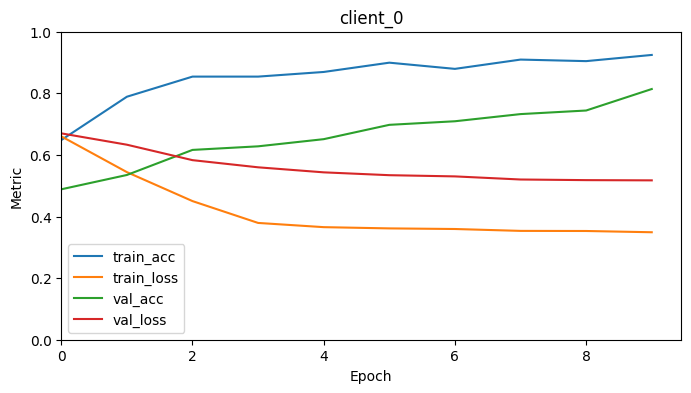

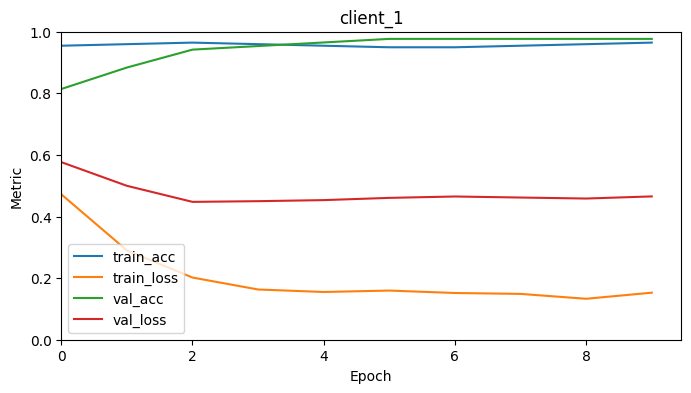

In [183]:
for client in fl_server.clients:
    plot_metrics(client, None)
    

Now we can compare the final performance of the centrally trained model against the model trained with federated learning.
The accuracies will not match perfectly, but they are close.

In [184]:
print("Centrally trained model accuracy:")
run_prediction(central_client.model)
print()
print("Model trained with federated learning accuracy:")
run_prediction(fl_server.model)

Centrally trained model accuracy:


TypeError: run_prediction() missing 1 required positional argument: 'test_data_path'

### Vertex AI


The training and validation client datasets are currently stored in your working environment. Create a cloud storage bucket and push these csv files to the bucket. Make sure you Bucket Name is universally unique or you will run into a error. 

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/pytorch-cu124.py310:latest",    
    packages_to_install=[
        "fl_packages @ git+https://github.com/STRIDES/NIHCloudLabGCP@fl-tutorial#subdirectory=notebooks/FederatedLearning/scripts"
    ]
)
def initialize_model(
    client_data_dir: str, 
    num_clients: int, 
    feature_inputs: int, 
    #model_output: Output[Model],
    clients_output: Output[Artifact]
    ):
    
    import torch
    import os
    import pickle
    import numpy as np
    import pandas as pd
    import torch.nn as nn

    from torch.nn import Sequential
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
    from sklearn.preprocessing import StandardScaler
        

    ## Step 1: Initialize clients and model
    # load the model
    fed_model = SimpleNN(n_input=feature_inputs)

    clients = []
    for i in range(num_clients):
        train_df = pd.read_csv(os.path.join(client_data_dir, f"client_{i}", "train_data.csv"), dtype=np.float32)
        val_df = pd.read_csv(os.path.join(client_data_dir, f"client_{i}", "val_data.csv"), dtype=np.float32)
        
        train_data = BreastCancerDataset(train_df)
        val_data = BreastCancerDataset(val_df)

        train_dataloader = DataLoader(train_data, batch_size=7, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=7, shuffle=False)

        optimizer = torch.optim.SGD(fed_model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.BCELoss()
    
        clients.append(Client(f"client_{i}", fed_model, train_dataloader, val_dataloader, optimizer, criterion))
    
    #save model
    #torch.save(fed_model.model.state_dict(), model_output.path)

    # Serialize and save the clients
    with open(clients_output.path, "wb") as f:
        pickle.dump(clients, f)
    

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project="cit-oconnellka-9999", location="us-central1")

pipeline_job = aiplatform.PipelineJob(
    display_name="example-pipeline",
    template_path="example-pipeline.json",
    pipeline_root=f"gs://{BUCKET}/pipeline_root-test/example-pipeline",
    parameter_values={
        "feature_inputs": 30,
    }
)

pipeline_job.run()

In [ ]:
import torch
import torch.nn as nn
from torch.nn import Sequential
from kfp.v2.dsl import component, pipeline



# Define the SimpleNN class globally


# Component to initialize the model
@component(base_image="gcr.io/deeplearning-platform-release/pytorch-cu124.py310:latest",
    packages_to_install=[
        "google-cloud-aiplatform",
        "google-cloud-storage",
        "gs://federated-learning-resources-zy-2/packages/my_package-0.1.tar.gz"
    ]
)
def initialize_model(feature_inputs: int):
    import google.cloud.storage
    from my_package.test_models_func import SimpleNN
    fed_model = SimpleNN(n_input=feature_inputs)
    print("Model initialized successfully")

# Define the pipeline
@pipeline(name="example-pipeline")
def example_pipeline(feature_inputs: int):
    initialize_model(feature_inputs=feature_inputs)

In [ ]:
!python scripts/setup.py sdist

In [ ]:
from kfp.v2 import compiler

compiler.Compiler().compile(
    pipeline_func=example_pipeline,
    package_path="example-pipeline.json"
)

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project="cit-oconnellka-9999", location="us-central1")

pipeline_job = aiplatform.PipelineJob(
    display_name="example-pipeline",
    template_path="example-pipeline.json",
    pipeline_root=f"gs://{BUCKET}/pipeline_root-test/example-pipeline",
    parameter_values={
        "feature_inputs": 30,
    }
)

pipeline_job.run()

In [ ]:
@component(base_image="gcr.io/deeplearning-platform-release/pytorch-cu124.py310:latest",  
           packages_to_install=[
               "google-cloud-aiplatform",
               "matplotlib",
               "ordereddict"
               ])
def train_model(
    #model_input: Input[Model],
    clients_input: Input[Artifact],
    epochs: int,
    feature_inputs: int,
    visualization_output: Output[Artifact],
    trained_model_output: Output[Model]
    ):

    import pickle
    import torch
    import matplotlib.pyplot as plt
    from collections import OrderedDict

    def fed_avg(global_state_dict, client_states, n_data_points):
        """
        Averages the weights of client models to update the global model by FedAvg.

        Args:
            global_state_dict: The state dict of the global PyTorch model.
            client_states: A list of PyTorch models state dicts representing client models.
            n_data_points: A list with the number of data points per client.

        Returns:
            The state dict of the updated global PyTorch model.
        """
        averaged_state_dict = OrderedDict()

        for key in global_state_dict.keys():
            for state, n in zip(client_states, n_data_points):
                averaged_state_dict[key] =+ state[key] * (n/ sum(n_data_points))
    
        return averaged_state_dict
    
    class FLServer:
        def __init__(self, model, clients):
            self.model = model
            self.clients = clients
            self.n_data_points = [len(client.train_loader.dataset) for client in self.clients]

        def run(self, epochs):
            for i in range(epochs):
                print(f"Epoch {i}")

                # Step 2 of figure at the beginning of the tutorial
                for client in self.clients:
                    client.train()

                # aggregate the models using FedAvg (Step 3 & 4 of figure at the beginning of the tutorial)
                client_states = [client.model.state_dict() for client in self.clients]                 # Step 3
                aggregated_state = fed_avg(self.model.state_dict(), client_states, self.n_data_points) # Step 4
                self.model.load_state_dict(aggregated_state)
                
                # redistribute central model (Step 1 of figure at the beginning of the tutorial)
                for client in fl_server.clients:
                    client.model.load_state_dict(aggregated_state)

                # run validation of aggregated model
                for client in self.clients:
                    client.validate()

                # repeat for n epochs (Step 5 of figure at the beginning of the tutorial


    def plot_metrics(client, op_save):
        plt.figure(figsize=(8, 4))
        for k, v in client.metrics.items():
            x_vals = range(len(v))
            plt.plot(x_vals, v, label=k)

        plt.ylim(bottom=0.0, top=1.0)
        plt.xlim(left=0)
        plt.xlabel("Epoch")
        plt.ylabel("Metric")
        plt.title(client.name)
        plt.legend()
        plt.show()
        if op_save is not None:
            plt.savefig(op_save.path)
        plt.close()
  
       # Load the model
    fed_model = SimpleNN(n_input=feature_inputs)
    #fed_model.load_state_dict(torch.load(model_input.path))

    # Load the clients
    with open(clients_input.path, "rb") as f:
        clients = pickle.load(f)

    # Step 2: Train the federated learning server
    fl_server = FLServer(fed_model, clients)
    # distribute the central model to all clients (Step 1 of figure at the beginning of the tutorial)
    for client in fl_server.clients:
        client.model.load_state_dict(fl_server.model.state_dict())

    #run training with server
    fl_server.run(epochs=epochs)

    #plot metrics for each client
    for client in fl_server.clients:
        client_plot_path = os.path.join(visualization_output.path, f"{client.name}_metrics.png")
        plot_metrics(client, client_plot_path)

    #save model
    torch.save(fl_server.model.state_dict(), trained_model_output.path)
    
    

In [ ]:
@component(base_image="gcr.io/deeplearning-platform-release/pytorch-cu124.py310:latest",
           packages_to_install=[
               "google-cloud-aiplatform"
               ])
def evaluate(
    model_input: Input[Model],
    test_data_path: str,
    feature_inputs: int,
    metrics_output: Output[Metrics]
    ):
   import pandas as pd

   from torch.utils.data import DataLoader

   def run_prediction(model, test_data_path):
        model.eval()
        
        test_df = pd.read_csv(test_data_path, dtype=np.float32)
        test_data = BreastCancerDataset(test_df)
        test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

        correct_predictions = 0

        # iterate over validation data loader and make predictions
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                labels = torch.unsqueeze(labels, 1)
                predicted = torch.round(outputs)
                correct_predictions += (predicted == labels).sum().item()

        # calculate overall acc.
        accuracy = correct_predictions / len(test_dataloader.dataset)
        
        print(f"{accuracy:.2f}")
   fed_model = SimpleNN(n_input=feature_inputs)     
   fed_model.load_state_dict(torch.load(model_input.path))

   #run prediction to check accuracy and save metrics
   with open(metrics_output.path, "w") as f:
        accuracy_m=run_prediction(fed_model.model, test_data_path)
        f.write(f"Model trained with federated learning accuracy: {accuracy_m}\n")

In [ ]:
from kfp.v2 import dsl
@dsl.pipeline(
    name="federated-learning-pipeline",
    description="A pipeline for federated learning with client initialization, training, and evaluation."
)
def federated_learning_pipeline(
    client_data_dir: str, 
    num_clients: int, 
    feature_inputs: int, 
    epochs: int,
    test_data_path: str,
    ):

    class BreastCancerDataset(Dataset):
        def __init__(self, df):
            scaler = StandardScaler()
            self.X = torch.tensor(scaler.fit_transform(df.iloc[:,1:-1].values))   # first (ID) and last (diagnisis) columns are excluded
            self.y =  torch.tensor(df.iloc[:,-1].values)                          # load the diagnosis (malignant=1, benign=0)
        
        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]
        
    class SimpleNN(nn.Module):
        def __init__(self, n_input):
            super(SimpleNN, self).__init__()
            self.NN = Sequential(
                nn.Linear(n_input, 32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16,1),
                nn.Sigmoid()
            )

        def forward(self, x):
            logits = self.NN(x)
            return logits
    class Client:
        def __init__(self, name, model, train_loader, val_loader, optimizer, criterion):
            self.name = name
            self.model = model
            self.optimizer = optimizer
            self.criterion = criterion
            self.train_loader = train_loader
            self.val_loader = val_loader
            self.metrics = dict({"train_acc": list(), "train_loss": list(), "val_acc": list(), "val_loss": list()})

            print(f"[INFO] Initialized client '{self.name}' with {len(train_loader.dataset)} train and {len(val_loader.dataset)} validation samples")
            
            
        def train(self):
            """
                Trains the model of the client for 1 epoch.
            """
            self.model.train()
            correct_predictions = 0
            running_loss = 0.0

            # iterate over training dataset
            for inputs, labels in self.train_loader:
                # make predictions
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                labels = torch.unsqueeze(labels, 1)

                # apply gradient
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                # calculate number of correct predictions
                predicted = torch.round(outputs)
                correct_predictions += (predicted == labels).sum().item()

            # calculate overall loss and acc.
            epoch_loss = running_loss / len(self.train_loader)
            accuracy = correct_predictions / len(self.train_loader.dataset)

            # save metrics
            self.metrics["train_acc"].append(accuracy)
            self.metrics["train_loss"].append(epoch_loss)
        
        def validate(self):
            """
                Validates the model of the client based on the given validation data loader.
            """
            self.model.eval()
            total_loss = 0
            correct_predictions = 0

            # iterate over validation data loader and make predictions
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    outputs = self.model(inputs)
                    labels = torch.unsqueeze(labels, 1)
                    loss = self.criterion(outputs, labels)

                    total_loss += loss.item()
                    predicted = torch.round(outputs)
                    correct_predictions += (predicted == labels).sum().item()

            # calculate overall loss and acc.
            average_loss = total_loss / len(self.val_loader)
            accuracy = correct_predictions / len(self.val_loader.dataset)

            # save metrics
            self.metrics["val_acc"].append(accuracy)
            self.metrics["val_loss"].append(average_loss)

        
        

    initialize_model_task = initialize_model(
        client_data_dir=client_data_dir,
        num_clients=num_clients,
        feature_inputs=feature_inputs)
    
    train_model_task = train_model(
        #model_input=initialize_model_task.outputs["model_output"],
        clients_input=initialize_model_task.outputs["clients_output"],
        epochs=epochs,
        feature_inputs=feature_inputs)
    
    evaluate_task = evaluate(
        model_input=train_model_task.outputs["trained_model_output"],
        test_data_path=test_data_path,
        feature_inputs=feature_inputs),
        
    

In [ ]:
from kfp.v2 import dsl
@dsl.pipeline(
    name="federated-learning-pipeline",
    description="A pipeline for federated learning with client initialization, training, and evaluation."
)
def federated_learning_pipeline(
    client_data_dir: str, 
    num_clients: int, 
    feature_inputs: int, 
    epochs: int,
    test_data_path: str,
    trained_model_output: Output[Model],
    test_metrics_output: Output[Artifact],
    visualization_output: Output[Artifact]
    ):

    ## Step 1: Initialize clients and model
    # load the model
    fed_model = SimpleNN(n_input=feature_inputs)

    clients = []
    for i in range(num_clients):
        train_df = pd.read_csv(os.path.join(client_data_dir, f"client_{i}", "train_data.csv"), dtype=np.float32)
        val_df = pd.read_csv(os.path.join(client_data_dir, f"client_{i}", "val_data.csv"), dtype=np.float32)
        
        train_data = BreastCancerDataset(train_df)
        val_data = BreastCancerDataset(val_df)

        train_dataloader = DataLoader(train_data, batch_size=7, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=7, shuffle=False)

        optimizer = torch.optim.SGD(fed_model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.BCELoss()
    
        clients.append(Client(f"client_{i}", fed_model, train_dataloader, val_dataloader, optimizer, criterion))
    
    # Step 2: Train the federated learning server
    fl_server = FLServer(fed_model, clients)
    # distribute the central model to all clients (Step 1 of figure at the beginning of the tutorial)
    for client in fl_server.clients:
        client.model.load_state_dict(fl_server.model.state_dict())

    #run training with server
    fl_server.run(epochs=epochs)

    #save model
    torch.save(fl_server.model.state_dict(), trained_model_output.path)
    
    #plot metrics for each client
    for client in fl_server.clients:
        client_plot_path = os.path.join(visualization_output.path, f"{client.name}_metrics.png")
        plot_metrics(client, client_plot_path)
        
    #run prediction to check accuracy and save metrics
    with open(test_metrics_output.path, "w") as f:
        f.write(f"Model trained with federated learning accuracy: {run_prediction(fl_server.model, test_data_path)}\n")

In [ ]:
from kfp.v2 import compiler

compiler.Compiler().compile(
    pipeline_func=federated_learning_pipeline,
    package_path="federated_learning_pipeline.json"
)

if you run into any errors run: `!gcloud auth login`

In [ ]:
#Create a Google cloud storage bucket.
BUCKET='federated-learning-resources-zy-2'

!gsutil mb gs://$BUCKET

Creating gs://federated-learning-resources-zy-2/...


Copy cleint data and the val testing data

In [ ]:
!gsutil cp -r data/client_0 gs://$BUCKET/data/
!gsutil cp -r data/client_1 gs://$BUCKET/data/
!gsutil cp data/full_val_data.csv gs://$BUCKET/data/

Copying file://data/client_1/train_data.csv [Content-Type=text/csv]...
Copying file://data/client_1/val_data.csv [Content-Type=text/csv]...            
- [2 files][ 62.0 KiB/ 62.0 KiB]                                                
Operation completed over 2 objects/62.0 KiB.                                     


In [ ]:
from google.cloud import aiplatform

aiplatform.init(project="cit-oconnellka-9999", location="us-central1")

pipeline_job = aiplatform.PipelineJob(
    display_name="federated-learning-pipeline",
    template_path="federated_learning_pipeline.json",
    pipeline_root=f"gs://{BUCKET}/pipeline_root/federated_learning_pipeline",
    parameter_values={
        "client_data_dir": f"gs://{BUCKET}/data",
        "num_clients": 2,
        "feature_inputs": 30,
        "epochs": 10,
        "test_data_path": f"gs://{BUCKET}/data/full_val_data.csv"
    }
)

pipeline_job.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/144763482491/locations/us-central1/pipelineJobs/federated-learning-pipeline-20250421093540
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/144763482491/locations/us-central1/pipelineJobs/federated-learning-pipeline-20250421093540')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/federated-learning-pipeline-20250421093540?project=144763482491
PipelineJob projects/144763482491/locations/us-central1/pipelineJobs/federated-learning-pipeline-20250421093540 current state:
3
PipelineJob projects/144763482491/locations/us-central1/pipelineJobs/federated-learning-pipeline-20250421093540 current state:
3
PipelineJob projects/144763482491/locations/us-central1/pipelineJobs/federated-learning-pipeline-20250421093540 current state:
3


RuntimeError: Job failed with:
code: 9
message: " The DAG failed because some tasks failed. The failed tasks are: [initialize-model].; Job (project_id = cit-oconnellka-9999, job_id = 6235174447905505280) is failed due to the above error.; Failed to handle the job: {project_number = 144763482491, job_id = 6235174447905505280}"


In [ ]:
from kfp.v2 import dsl

@dsl.pipeline(
    name="federated-learning-pipeline",
    description="A pipeline for Federated Learning with tabular data."
)
def federated_learning_pipeline(
    input_data_path: str,
    num_clients: int,
    output_dir: str,
    validation_data_path: str,
    epochs: int
):
    # Step 1: Prepare data
    prepare_task = prepare_data(
        input_data_path=input_data_path,
        num_clients=num_clients,
        output_dir=output_dir
    )
    
    # Step 2: Client training
    client_tasks = []
    for i in range(num_clients):
        client_task = client_training(
            client_data_path=f"{output_dir}/client_{i}/train_data.csv",
            epochs=epochs
        )
        client_tasks.append(client_task)
    
    # Step 3: Aggregate models
    aggregate_task = aggregate_models(
        client_models=[task.outputs["model_output"] for task in client_tasks]
    )
    
    # Step 4: Evaluate model
    evaluate_task = evaluate_model(
        model=aggregate_task.outputs["aggregated_model"],
        validation_data=validation_data_path
    )

In [ ]:
from kfp.v2 import compiler
from google.cloud import aiplatform

# Compile the pipeline
compiler.Compiler().compile(
    pipeline_func=federated_learning_pipeline,
    package_path="federated_learning_pipeline.json"
)

# Submit the pipeline
aiplatform.init(project="your-project-id", location="us-central1")

pipeline_job = aiplatform.PipelineJob(
    display_name="federated-learning-pipeline",
    template_path="federated_learning_pipeline.json",
    parameter_values={
        "input_data_path": "gs://your-bucket/input-data.csv",
        "num_clients": 3,
        "output_dir": "gs://your-bucket/output",
        "validation_data_path": "gs://your-bucket/validation-data.csv",
        "epochs": 5
    }
)

pipeline_job.run()

Store the path of these files in their respective variable names. 

In [ ]:
# save client datasets to path
client_0_input_path = f'gs://$BUCKET/data/client_0'

# save validation_dataset to gc bucket
client_1_input_path = f'gs://$BUCKET/data/client_1'

Create a python script called task.py in a folder called "scripts". This script adapts the code snippets run above to work with resources from cloud storage. 

Create a file called "setup.py" in your working directory. When this script is run, it will create a python package that contains all of the dependcies of your run. 


```python
from setuptools import find_packages
from setuptools import setup

setup(
    name='breast_cancer_federated_learning',
    version='0.1',
    install_requires=[
        'torch',
        'numpy',
        'pandas',
        'matplotlib',
        'scikit-learn',
        'google-cloud-storage',
        'google-cloud-aiplatform',
    ],
    packages=find_packages(),
    include_package_data=True,
    description='Breast Cancer Federated Learning Training Script',
)
```

Run setup.py.

In [ ]:
! python3 ./scripts/setup.py sdist bdist_wheel

Copy the python package to your cloud storage bucket. 

In [ ]:
!gsutil cp dist/breast_cancer_federated_learning-0.1-py3-none-any.whl gs://{BUCKET}

Submit the training job. 

Upload the model to the Vertex AI Model Registry. This will allow you to deploy endpoints using the model. 

Create an endpoint and deploy it to the model. 

## Additional resources

If you are further interested in Federated Learning here are some useful resources to continue your FL journey.

### Other Tutorials:
- [TensorFlow](https://www.tensorflow.org/federated/tutorials/building_your_own_federated_learning_algorithm)
- [FLOWER](https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html)

### Frameworks:
- [NVFLare](https://developer.nvidia.com/flare)
- [TensorFlow](https://www.tensorflow.org/federated)
- [FLOWER](https://flower.ai/docs/framework/index.html)
- [FeatureCloud](https://featurecloud.ai/)

### Literature:
[1] Rieke et al., (2020), "[The future of digital health with federated learning](https://www.nature.com/articles/s41746-020-00323-1)"

[2] Zhang et al., (2021), "[A survey on federated learning](https://www.sciencedirect.com/science/article/pii/S0950705121000381)"

[3] Wolberg et al., (1993), [Breast Cancer Wisconsin (Diagnostic)](https://doi.org/10.24432/C5DW2B)

[4] McMahan et al., (2017), "[Communication-Efficient Learning of Deep Networks from Decentralized Data](https://proceedings.mlr.press/v54/mcmahan17a.html)"

